# House price prediction

# Steps:


1.Importing libraries and dataset

2.Knowing the data and exploring some variables

3.Data Preprocessing

4.Modelling

## 1. Importing libraries and dataset

In [389]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.express as px
data = pd.read_csv('Task-Dirtydata.csv')

## 2.Knowing the data and exploring some variables

In [390]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5470 entries, 0 to 5469
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   location        5470 non-null   object 
 1   price           5470 non-null   int64  
 2   bill_of_sale    5470 non-null   object 
 3   mortgage        5470 non-null   object 
 4   repair          5470 non-null   object 
 5   area_m2         5470 non-null   float64
 6   number_of_room  5470 non-null   int64  
 7   floor           5470 non-null   int64  
 8   date            5470 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 384.7+ KB


In [391]:
data = data.drop('date', axis=1)

In [392]:
data.head()
data.groupby(['location'])['price'].transform('sum') / data.groupby(['location'])['area_m2'].transform('sum')

0       2262.338887
1       2404.484841
2       2262.338887
3       2350.355688
4       1573.424658
           ...     
5465    2404.484841
5466    2404.484841
5467    2292.720683
5468    2350.355688
5469    2262.338887
Length: 5470, dtype: float64

In [393]:
data['price_per_m2'] = data.groupby(['location'])['price'].transform('sum') / data.groupby(['location' ])['area_m2'].transform('sum')

In [394]:
data.head()

,location,price,bill_of_sale,mortgage,repair,area_m2,number_of_room,floor,price_per_m2
0,Nərimanov r.,410000,Çıxarış var,Ipoteka yoxdur,Təmirli,200.0,4,2,2262.338887
1,Gənclik m.,185000,Çıxarış yoxdur,Ipoteka yoxdur,Təmirli,61.0,2,3,2404.484841
2,Nərimanov r.,418404,Çıxarış yoxdur,Ipoteka yoxdur,Təmirsiz,199.2,5,12,2262.338887
3,Nəriman Nərimanov m.,159000,Çıxarış var,İpoteka var,Təmirli,55.0,2,5,2350.355688
4,Koroğlu m.,269000,Çıxarış var,Ipoteka yoxdur,Təmirli,172.0,3,15,1573.424658


In [395]:
data['location'].value_counts()

location
Nəriman Nərimanov m.     2463
Nərimanov r.             1856
Gənclik m.                759
28 May m.                 252
8 Noyabr m.                48
Koroğlu m.                 29
Dərnəgül m.                21
Bakmil m.                  14
Azadlıq Prospekti m.        7
Şah İsmayıl Xətai m.        6
Böyükşor q.                 3
Nizami m.                   3
İçəri Şəhər m.              2
İnşaatçılar m.              2
20 Yanvar m.                1
Sahil m.                    1
Qara Qarayev m.             1
Elmlər Akademiyası m.       1
Ulduz m.                    1
Name: count, dtype: int64

In [396]:
values_to_drop = ['Azadlıq Prospekti m.', 'Şah İsmayıl Xətai m.', 'Böyükşor q.', 'Nizami m.', 'İçəri Şəhər m.',
                  'İnşaatçılar m.', '20 Yanvar m.', 'Sahil m.', 'Qara Qarayev m.', 'Elmlər Akademiyası m.', 'Ulduz m.']
data = data[~data['location'].isin(values_to_drop)]


In [397]:
data.describe()

,price,area_m2,number_of_room,floor,price_per_m2
count,5.442000e+03,5442.000000,5442.000000,5442.000000,5442.000000
mean,2.837471e+05,122.492576,2.879456,9.277655,2318.856591
std,1.809795e+05,59.609617,0.889288,4.475986,76.310099
min,6.900000e+04,30.000000,1.000000,1.000000,1573.424658
25%,1.947000e+05,81.000000,2.000000,5.000000,2262.338887
50%,2.600000e+05,112.000000,3.000000,9.000000,2350.355688
75%,3.250000e+05,150.000000,3.000000,13.000000,2350.355688
max,3.600000e+06,830.000000,15.000000,21.000000,2404.484841


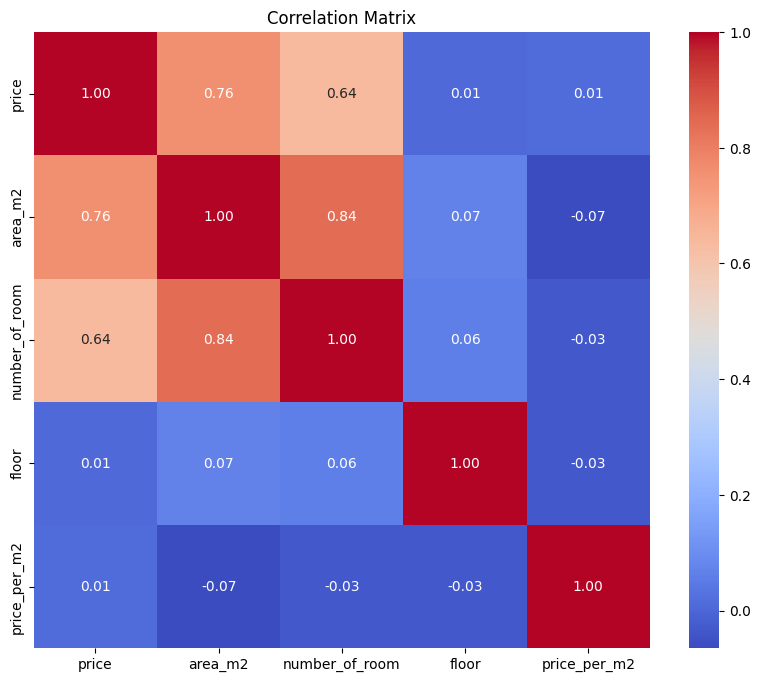

In [398]:
columns_to_correlate = ['price', 'area_m2', 'number_of_room', 'floor', 'price_per_m2']

correlation_matrix = data[columns_to_correlate].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.show()

In [399]:
fig = px.scatter_matrix(data, dimensions=
['area_m2', 'floor','price_per_m2','number_of_room'],
labels={col:col.replace('_', ' ') for col in data.columns},           height=900, color='price', color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

In [400]:
data=data[data['number_of_room'] <= 8]

In [401]:
column_name = 'price'  

Q1 = data[column_name].quantile(0.25)
Q3 = data[column_name].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


outliers = data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)]
data_no_outliers = data[(data[column_name] >= lower_bound) & (data[column_name] <= upper_bound)]

print(f"Total data points: {len(data)}")
print(f"Number of outliers: {len(outliers)}")
print(f"Data points without outliers: {len(data_no_outliers)}")

Total data points: 5439
Number of outliers: 195
Data points without outliers: 5244


In [402]:
data=data_no_outliers
column_name = 'area_m2'  

Q1 = data[column_name].quantile(0.25)
Q3 = data[column_name].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


outliers = data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)]
data_no_outliers = data[(data[column_name] >= lower_bound) & (data[column_name] <= upper_bound)]

print(f"Total data points: {len(data)}")
print(f"Number of outliers: {len(outliers)}")
print(f"Data points without outliers: {len(data_no_outliers)}")
data=data_no_outliers

Total data points: 5244
Number of outliers: 40
Data points without outliers: 5204


In [403]:
data.describe()

,price,area_m2,number_of_room,floor,price_per_m2
count,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000
mean,260217.113374,115.168966,2.798616,9.261530,2319.443307
std,85916.312247,43.545996,0.784110,4.462737,75.721158
min,69000.000000,30.000000,1.000000,1.000000,1573.424658
25%,192000.000000,80.000000,2.000000,5.000000,2262.338887
50%,255000.000000,109.000000,3.000000,9.000000,2350.355688
75%,319000.000000,144.000000,3.000000,13.000000,2350.355688
max,520000.000000,240.000000,7.000000,21.000000,2404.484841


In [404]:
average_prices = data.groupby(['repair', 'location'])['price'].mean()
median_prices= data.groupby(['repair', 'location'])['price'].median()
print(average_prices)
print(median_prices)

repair    location            
Təmirli   28 May m.               238519.886364
          8 Noyabr m.             230677.419355
          Bakmil m.               231530.769231
          Dərnəgül m.             182402.722222
          Gənclik m.              262031.003960
          Koroğlu m.              241888.888889
          Nəriman Nərimanov m.    260777.076301
          Nərimanov r.            256782.612046
Təmirsiz  28 May m.               219496.561644
          8 Noyabr m.             216547.117647
          Bakmil m.               187000.000000
          Dərnəgül m.             280333.333333
          Gənclik m.              268629.599078
          Koroğlu m.              252716.666667
          Nəriman Nərimanov m.    262649.072727
          Nərimanov r.            275280.099338
Name: price, dtype: float64
repair    location            
Təmirli   28 May m.               215000.0
          8 Noyabr m.             210000.0
          Bakmil m.               229900.0
          Dər

In [405]:
difference_in_prices = average_prices['Təmirli'] - average_prices['Təmirsiz']
print(difference_in_prices)

location
28 May m.               19023.324720
8 Noyabr m.             14130.301708
Bakmil m.               44530.769231
Dərnəgül m.            -97930.611111
Gənclik m.              -6598.595118
Koroğlu m.             -10827.777778
Nəriman Nərimanov m.    -1871.996427
Nərimanov r.           -18497.487292
Name: price, dtype: float64


In [406]:
difference_in_median_prices = median_prices['Təmirli'] - median_prices['Təmirsiz']
print(difference_in_median_prices)

location
28 May m.              -10000.0
8 Noyabr m.              3200.0
Bakmil m.               42900.0
Dərnəgül m.            -70500.0
Gənclik m.                  0.0
Koroğlu m.             -42000.0
Nəriman Nərimanov m.    -1500.0
Nərimanov r.            -8000.0
Name: price, dtype: float64


In [408]:
average_prices_for_location= data.groupby(['location'])['price'].mean()
print(average_prices_for_location)

location
28 May m.               232942.767068
8 Noyabr m.             225672.937500
Bakmil m.               228350.000000
Dərnəgül m.             196392.809524
Gənclik m.              264014.238227
Koroğlu m.              249107.407407
Nəriman Nərimanov m.    261294.029289
Nərimanov r.            263229.514714
Name: price, dtype: float64


Text(0.5, 9.444444444444438, 'house prices')

<Figure size 1000x400 with 0 Axes>

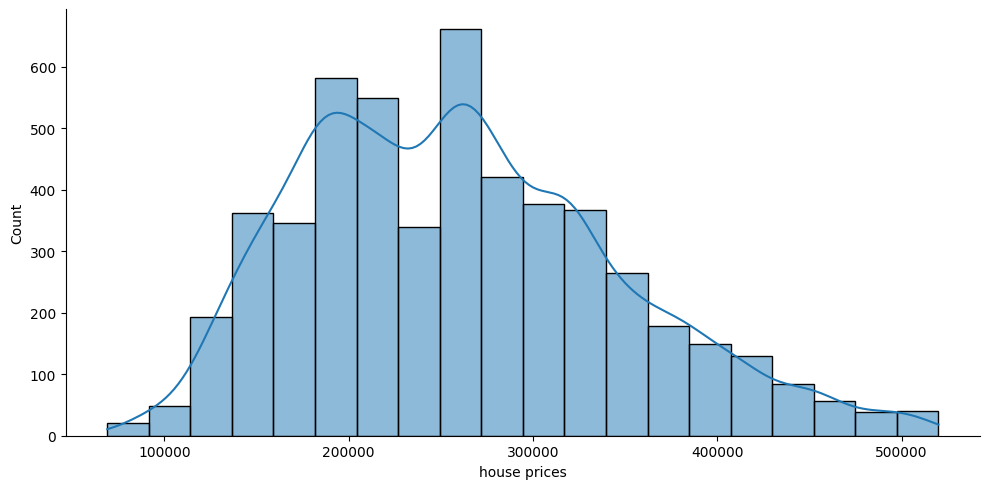

In [410]:
plt.figure(figsize=(10,4))
sns.displot(data['price'],kde=True,bins=20, aspect=2)
plt.xlabel('house prices')

# 3.Data Preprocessing

In [411]:
data['bill_of_sale'] = data['bill_of_sale'].replace({'Çıxarış yoxdur': 0, 'Çıxarış var': 1})
data['mortgage'] = data['mortgage'].replace({'Ipoteka yoxdur': 0, 'İpoteka var': 1})
data['repair'] = data['repair'].replace({'Təmirsiz': 0, 'Təmirli': 1})
data = data.drop('location', axis=1)

In [412]:
scaler = MinMaxScaler()
scale_col = ['area_m2', 'number_of_room', 'floor', 'price_per_m2']
data[scale_col] = scaler.fit_transform(data[scale_col])

In [413]:
import pickle
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [414]:
data

,price,bill_of_sale,mortgage,repair,area_m2,number_of_room,floor,price_per_m2
0,410000,1,0,1,0.809524,0.500000,0.05,0.828958
1,185000,0,0,1,0.147619,0.166667,0.10,1.000000
2,418404,0,0,0,0.805714,0.666667,0.55,0.828958
3,159000,1,1,1,0.119048,0.166667,0.20,0.934867
4,269000,1,0,1,0.676190,0.333333,0.70,0.000000
...,...,...,...,...,...,...,...,...
5465,225000,0,0,0,0.442857,0.333333,0.50,1.000000
5466,232000,0,0,1,0.357143,0.333333,0.35,1.000000
5467,150000,0,0,0,0.371429,0.166667,0.20,0.865516
5468,190000,0,0,0,0.309524,0.333333,0.75,0.934867


## 4.Modelling

In [415]:
X = data.drop('price', axis=1)
y = data['price']

In [416]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [417]:
X_train.head()

,bill_of_sale,mortgage,repair,area_m2,number_of_room,floor,price_per_m2
3851,1,0,0,0.395238,0.333333,0.75,0.828958
4237,0,0,0,0.619048,0.333333,0.55,0.828958
3282,1,0,0,0.390476,0.333333,0.55,0.828958
5069,1,1,1,0.338095,0.333333,0.35,0.934867
1809,1,1,1,0.761905,0.500000,0.25,0.828958


In [418]:
rfr = RandomForestRegressor(max_depth=8, random_state=42)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, random_state=42)

In [419]:
y_pred_rfr = rfr.predict(X_test)

In [420]:
r2_rfr = r2_score(y_test, y_pred_rfr)
MAE_rfr = metrics.mean_absolute_error(y_test,y_pred_rfr)
MSE_rfr = metrics.mean_squared_error(y_test,y_pred_rfr)
RMSE_rfr = np.sqrt(MSE_rfr)
pd.DataFrame([MAE_rfr,MSE_rfr,RMSE_rfr],index=['MAE', 'MSE', 'RMSE'], columns=['Metrics'])

,Metrics
MAE,2.478175e+04
MSE,1.288136e+09
RMSE,3.589061e+04


In [421]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)  
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [422]:
y_pred_xgb = xgb.predict(X_test)

In [434]:
r2_xgb = r2_score(y_test, y_pred_xgb)
MAE_xgb = metrics.mean_absolute_error(y_test,y_pred_xgb)
MSE_xgb = metrics.mean_squared_error(y_test,y_pred_xgb)
RMSE_xgb = np.sqrt(MSE_xgb)
pd.DataFrame([MAE_xgb,MSE_xgb,RMSE_xgb],index=['MAE', 'MSE', 'RMSE'], columns=['Metrics'])

,Metrics
MAE,2.310873e+04
MSE,1.198614e+09
RMSE,3.462100e+04


In [424]:
r2_xgb

0.8398367775018966

In [425]:
lgb = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)  
lgb.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 3642, number of used features: 7
[LightGBM] [Info] Start training from score 260619.133443


LGBMRegressor(random_state=42)

In [426]:
y_pred_lgb = lgb.predict(X_test)

In [435]:
r2_lgb = r2_score(y_test, y_pred_lgb)
MAE_lgb = metrics.mean_absolute_error(y_test,y_pred_lgb)
MSE_lgb = metrics.mean_squared_error(y_test,y_pred_lgb)
RMSE_lgb = np.sqrt(MSE_lgb)
pd.DataFrame([MAE_lgb,MSE_lgb,RMSE_lgb],index=['MAE', 'MSE', 'RMSE'], columns=['Metrics'])

,Metrics
MAE,2.322051e+04
MSE,1.182998e+09
RMSE,3.439474e+04


In [428]:
r2_rfr

0.8278744619007503

In [429]:
r2_xgb

0.8398367775018966

In [430]:
r2_lgb

0.8419233552594463

In [431]:
test_residual= y_test - y_pred_lgb

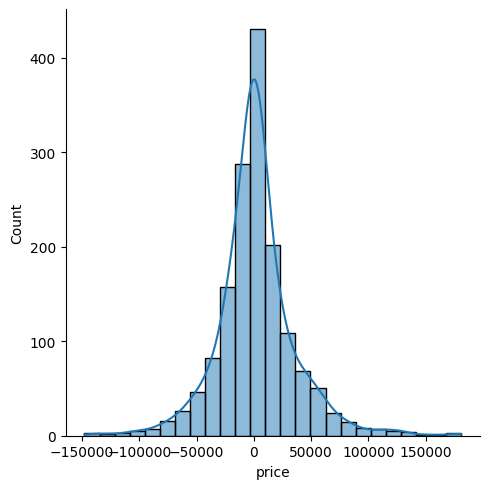

In [432]:
sns.displot(test_residual, bins=25, kde=True)

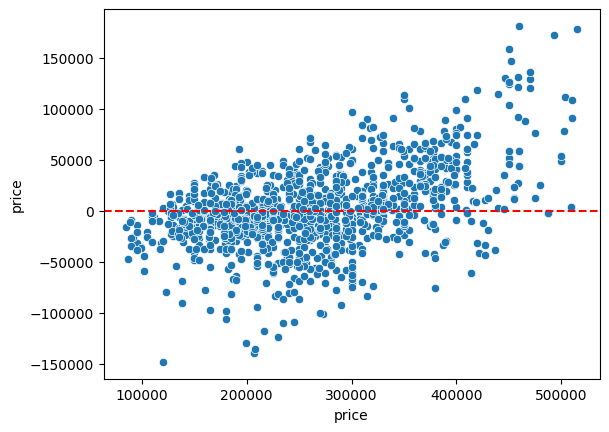

In [433]:
sns.scatterplot(x=y_test, y=test_residual)

plt.axhline(y=0, color='r', ls='--')